In [5]:
import torch
from sklearn.datasets import fetch_openml
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.utils.data as dset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from tensorflow import keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()



In [8]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization)
])
# testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization)
])

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X
batch_size = 300
train_set = ImgDataset(X_train, y_train, train_transform)
val_set = ImgDataset(X_test, y_test, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [1, 28, 28]
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 25, 3),  # [25, 26, 26]
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [25, 13, 13]

            nn.Conv2d(25, 50, 3), # [50, 11, 11]
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [50, 5, 5]
        )
        self.fc = nn.Sequential(
            nn.Linear(50*5*5, 1000),
            nn.Sigmoid(),
            nn.Linear(1000, 500),
            nn.Sigmoid(),
            nn.Linear(500, 300),
            nn.Sigmoid(),
            nn.Linear(300, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [ ]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 15
LOSS = 0
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        # for j in data[0]:
        #     print(j)
        train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
        
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        #將結果 print 出來
        LOSS = val_loss/val_set.__len__()
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))





[001/015] 8.97 sec(s) Train Acc: 0.681917 Loss: 0.005967 | Val Acc: 0.899000 loss: 0.005315
[002/015] 8.76 sec(s) Train Acc: 0.974717 Loss: 0.004973 | Val Acc: 0.982500 loss: 0.005033
[003/015] 8.65 sec(s) Train Acc: 0.982983 Loss: 0.004932 | Val Acc: 0.985100 loss: 0.005021
[004/015] 8.68 sec(s) Train Acc: 0.984800 Loss: 0.004925 | Val Acc: 0.984700 loss: 0.005022
[005/015] 8.76 sec(s) Train Acc: 0.987717 Loss: 0.004913 | Val Acc: 0.986000 loss: 0.005017
[006/015] 8.73 sec(s) Train Acc: 0.988850 Loss: 0.004910 | Val Acc: 0.986000 loss: 0.005018
[007/015] 8.76 sec(s) Train Acc: 0.990300 Loss: 0.004904 | Val Acc: 0.988200 loss: 0.005007
[008/015] 8.89 sec(s) Train Acc: 0.991217 Loss: 0.004901 | Val Acc: 0.989400 loss: 0.005005
[009/015] 8.79 sec(s) Train Acc: 0.991483 Loss: 0.004900 | Val Acc: 0.986400 loss: 0.005016
[010/015] 8.78 sec(s) Train Acc: 0.991767 Loss: 0.004899 | Val Acc: 0.990200 loss: 0.005002
[011/015] 8.85 sec(s) Train Acc: 0.993033 Loss: 0.004895 | Val Acc: 0.988100 los

In [ ]:
EPOCH = 20
PATH = "drive/My Drive/ML/hello_world_mnist.ipynb/model.pt"


torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

saving checkpoint

In [4]:
model = Classifier().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
PATH = "drive/My Drive/ML/hello_world_mnist.ipynb/model.pt"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

loading data in checkpoint

In [10]:
import numpy as np


class diffrential_evolution():
    def __init__(self):
        self.parent = np.random.randint(28, size=(population, pixels * 3)).astype(float)
        self.target_fittness = np.zeros((population, 10))
        self.mutation = 0.01
        self.image_size = 28
        self.cross_rate = 0.3
        for i in range(pixels * 3):
            if (i+1) % 3 == 0:
                self.parent[:,i] = np.random.uniform(0,1,[population])

    def cross_over(self, good_rate=0.1):
        superior_parent = int(population * good_rate)
       
        # self.target_fittness = np.sort(self.target_fittness)[::-1]
        good = self.parent[0:superior_parent]
        parent1, parent2 = np.split(good, 2)
        list_ = []
        for i in range(int(superior_parent*self.cross_rate)):
            list_.append(good[i])
        for i in range(population - int(superior_parent*self.cross_rate)):
            indiv_1 = parent1[np.random.randint(0,parent1.shape[0])]
            indiv_2 = parent1[np.random.randint(0,parent2.shape[0])]
            mask = np.random.randint(1, size=pixels * 3).astype(float)
            for j in range(pixels * 3):
                if mask[j] == 1:
                    mask[j] = indiv_1[j]
                else:
                    mask[j] = indiv_2[j]

            if np.random.uniform(0,1) < self.mutation:
                for k in range(pixels * 3):
                    if (k+1) % 3 == 0:
                        mask[k] =  np.random.uniform(0,1)
                    else:
                        mask[k] =  float(np.random.randint(0, 28))

            list_.append(mask)
    
        self.parent = np.array(list_)


    def fittness(self, data, targetted = True): # target or untarget
        data_img = np.copy(data)
        for i in range(data_img.shape[0]):
            for j in range(0, pixels * 3, 3):
                data_img[i][int(self.parent[i][j])][int(self.parent[i][j+1])] = np.clip(0,1,self.parent[i][j+2] + data_img[i][int(self.parent[i][j])][int(self.parent[i][j+1])])
        tmp_img = data_img
        data_img = np.clip(0,1,np.reshape(data_img, [population,1,28,28]))

        X = torch.from_numpy(data_img).cuda("cuda:0").float()
        train_pred = model(X).cpu().detach().numpy()

        if targetted:
            self.target_fittness = train_pred[:,adv_target]
        else:
            self.target_fittness = -train_pred[:,adv_target]
        arr1inds = self.target_fittness.argsort()
        self.parent = self.parent[arr1inds[::-1]]

        return self.parent[np.argmax(self.target_fittness, axis=0)], np.amax(self.target_fittness), tmp_img[np.argmax(self.target_fittness, axis=0)]






In [23]:
sample = 15
adv_target = 8
population = 20000
pixels = 1


list_ = []
for i in range(population):
    list_.append(X_test[sample]/255)

arr = np.array(list_) # pre-processing image dataset


df = diffrential_evolution()
target_img = np.copy(X_test[sample]/255)
final_vec = []
for i in range(10):
    print("generation", i+1, ":")
    df = diffrential_evolution()
    fitness = -1
    vec, fitness, target_img = df.fittness(arr, targetted = True)
    df.cross_over()
    print(fitness)
    final_vec.append(vec)

    if (fitness > 0.9):
            break
    list_ = []
    for i in range(population):
        list_.append(target_img)

    arr = np.array(list_)
    





generation 1 :
3.0224467e-06
generation 2 :
0.0072536166
generation 3 :
0.7251826
generation 4 :
0.96177286


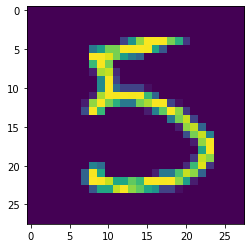

In [20]:
plt.imshow(X_test[15]/255)

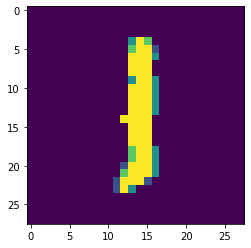

[[2.55037918e-07 8.34573730e-05 1.51509948e-06 9.99821484e-01
  4.41550663e-09 7.86460514e-05 3.56650931e-09 6.16070110e-07
  1.29356695e-05 1.18417006e-06]]
[array([9.        , 4.        , 0.01629171])]


In [ ]:

plt.imshow(target_img)
plt.show()
data = np.reshape(target_img, [1,1,28,28])
X = torch.from_numpy(data).cuda("cuda:0").float()
train_pred = model(X).cpu().detach().numpy()
print(train_pred)
print(final_vec)

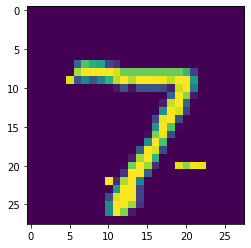

[[1.70114712e-04 3.49292834e-03 8.86840641e-01 3.68894180e-05
  1.57392133e-05 2.81073764e-09 1.63547931e-08 1.09440565e-01
  3.04890546e-06 8.30707592e-08]]
[array([1.        , 2.        , 0.56864958]), array([ 3.        , 24.        ,  0.12557563]), array([27.        , 27.        ,  0.48129637]), array([17.        ,  0.        ,  0.80718864]), array([18.        , 10.        ,  0.71068385]), array([18.        , 25.        ,  0.74197651])]


In [13]:

plt.imshow(target_img)
plt.show()
data = np.reshape(target_img, [1,1,28,28])
X = torch.from_numpy(data).cuda("cuda:0").float()
train_pred = model(X).cpu().detach().numpy()
print(train_pred)
print(final_vec)

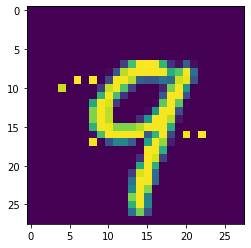

[[6.6660350e-06 9.0574931e-06 2.3009689e-04 2.0638127e-04 1.7500141e-03
  8.0833829e-08 1.0641783e-09 9.6114165e-01 2.1836492e-03 3.4472439e-02]]
[array([26.        , 25.        ,  0.99178555]), array([ 4.        , 25.        ,  0.36803198]), array([ 3.        , 15.        ,  0.82374363]), array([22.        , 12.        ,  0.05440888]), array([14.        , 24.        ,  0.60746043]), array([27.        ,  9.        ,  0.89035146])]


In [19]:

plt.imshow(target_img)
plt.show()
data = np.reshape(target_img, [1,1,28,28])
X = torch.from_numpy(data).cuda("cuda:0").float()
train_pred = model(X).cpu().detach().numpy()
print(train_pred)
print(final_vec)

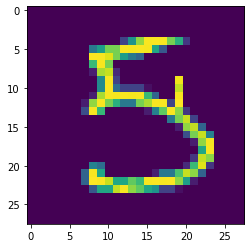

[[3.5376885e-04 1.7472474e-04 5.9888269e-05 9.7221829e-02 6.8582858e-07
  1.3864028e-01 2.4798885e-06 3.1661490e-05 7.6189125e-01 1.6233192e-03]]
[array([ 8.        , 24.        ,  0.20482447]), array([ 2.      , 23.      ,  0.828007]), array([6.        , 3.        , 0.11120308]), array([3.        , 2.        , 0.58394012])]


In [25]:

plt.imshow(target_img)
plt.show()
data = np.reshape(target_img, [1,1,28,28])
X = torch.from_numpy(data).cuda("cuda:0").float()
train_pred = model(X).cpu().detach().numpy()
print(train_pred)
print(final_vec)